In [16]:
# py27 compatability
from __future__ import print_function
from __future__ import division
# load packages
import numpy as np                                          # advanced array functions
import pandas as pd                                         # DataFrames
import matplotlib.pyplot as plt                             # plotting
from mpl_toolkits.axes_grid1 import make_axes_locatable
# configure matplotlib
%matplotlib inline
import seaborn as sns                                       # statistics / plotting
sns.set(style="ticks", font_scale=1.25)
from tqdm import tqdm, trange                                      # progress bar
import sspals
from mc_positronium import *

In [27]:
# simulate Ps converter
num = 1e6
reps = 25
# transition via n=2
lyman_a = Spectroscopy(lambda_0=243.0e-9, linewidth=1.0/(2*np.pi*3.2e-9))
ol_threshold = 0.001
# laser on
laser0 = Laser(wavelength=243.0e-9, trigger=2e-8, height=0.008)
# geometry
radius = 0.02
chamber = Tube(radius=radius)

# convolve
dt = 1e-9
bins = np.arange(-5e-8, 8e-7, dt)
pwo = detector(np.arange(-1e-8, 2e-7, dt), 1e-8)
B_vals = np.arange(0, 6e-7, 1e-8)

# measurement
fd = []
fb = []
for rep in trange(reps):
    noise = 0.001
    # background
    background = Ps_converter(num, T=600)
    off = chamber.hit(background)
    lt_off = np.histogram(off['time of death'].values, bins=bins, density=False)[0] 
    spectrum_off = np.convolve(lt_off, pwo)
    yscale = 1.0 / np.max(spectrum_off)
    spectrum_off = spectrum_off * yscale
    spectrum_off = spectrum_off + noise * np.random.randn(len(spectrum_off))
    # signal
    dist = Ps_converter(num, T=600)
    sig = lyman_a.rydberg(dist, laser0, ol_threshold, ex_eff=0.5, life_ryd=2e-6)
    on  = chamber.hit(sig)
    lt = np.histogram(on['time of death'].values, bins=bins, density=False)[0]
    #                    weights=solid_angle(on['z'], 0.04))[0]
    spectrum = np.convolve(lt, pwo) *yscale
    spectrum = spectrum + noise * np.random.randn(len(spectrum))
    for B in B_vals:
        limits = [-1.0E-8, B, 7e-7]
        fb.append(sspals.sspals_1D(spectrum_off, dt, limits=limits)['DF'][0])
        fd.append(sspals.sspals_1D(spectrum, dt, limits=limits)['DF'][0])
    del background, off, lt_off, spectrum_off
    del dist, sig, on, lt, spectrum
fd = np.array([fd]).reshape((reps, len(B_vals)))
fb = np.array([fb]).reshape((reps, len(B_vals)))

100%|██████████| 25/25 [04:26<00:00, 10.66s/it]


In [28]:
fb_av = np.mean(fb, axis=0)
fb_err = np.std(fb, axis=0) / np.sqrt(reps)
fd_av = np.mean(fd, axis=0)
fd_err = np.std(fd, axis=0) / np.sqrt(reps)
s_gamma = sspals.signal(fd_av, fd_err, fb_av, fb_err)

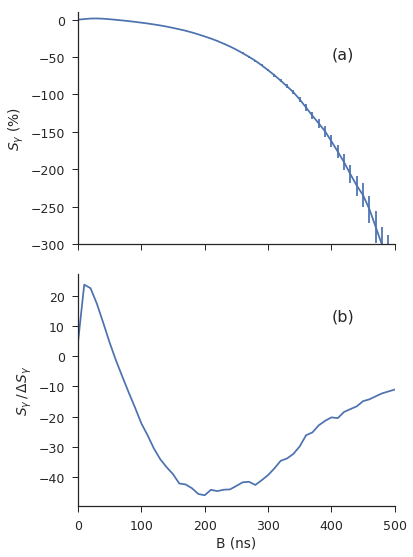

In [29]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(6, 8))
ax[0].errorbar(B_vals*1e9, s_gamma[0], s_gamma[1])
ax[0].set_xlim(0, 500)
ax[0].set_ylim(-300, 10)
ax[1].plot(B_vals*1e9, s_gamma[0] / s_gamma[1])

ax[1].set_xlabel('B (ns)')
ax[0].set_ylabel('$S_\gamma$ (%)')
ax[1].set_ylabel('$S_\gamma \, / \,  \Delta S_\gamma$')

ax[0].annotate('(a)', xy=(0.8, 0.8), xycoords='axes fraction', fontsize=16)
ax[1].annotate('(b)', xy=(0.8, 0.8), xycoords='axes fraction', fontsize=16)
sns.despine()
plt.tight_layout()
plt.savefig("../images/mc_ryd_snr.pdf", dpi=200, bbox_inches='tight')
plt.show()